In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import glob
import struct
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def BinToPcd(point_file):
    size_float = 4
    list_pcd = []
    file_to_open = point_file
    file_to_save = str(point_file)[:-3]+"pcd"
    with open(file_to_open, "rb") as f:
        byte = f.read(size_float*4)
        while byte:
            x,y,z,intensity = struct.unpack("ffff", byte)
            list_pcd.append([x,y,z])
            byte = f.read(size_float*4)
    np_pcd = np.asarray(list_pcd)
    pcd = o3d.geometry.PointCloud()
    v3d = o3d.utility.Vector3dVector
    pcd.points = v3d(np_pcd)
    o3d.io.write_point_cloud(file_to_save, pcd)

# Read bin files
point_files = sorted(glob.glob("./../data/2011_09_28/2011_09_28_sync/velodyne_points/data/*.bin"))
image_files = sorted(glob.glob("./../data/2011_09_28/2011_09_28_sync/image_02/data/*.png"))
print(point_files)
print(image_files)

['./../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000000.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000001.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000002.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000003.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000004.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000005.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000006.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000007.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000008.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000009.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000010.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000011.bin', './../data/2011_09_28/2011_09_28_sync/velodyne_points/data/0000000012.bin', './../data/

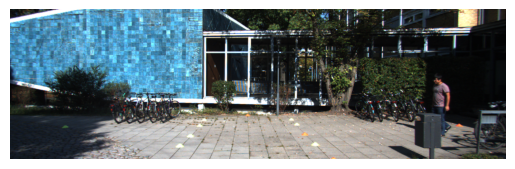

In [ ]:
file_index = 1
img = image_files[file_index]
binary = point_files[file_index]

temp_im = cv2.imread(img)
temp_im = cv2.cvtColor(temp_im, cv2.COLOR_BGR2RGB)

plt.imshow(temp_im)
plt.axis('off')
plt.show()


In [62]:
## Calibration matrix composition
with open(f'./../data/2011_09_28/calib_cam_to_cam.txt','r') as f:
    calib_cam2cam = f.readlines()
with open(f'./../data/2011_09_28/calib_velo_to_cam.txt','r') as f:
    calib_vel2cam = f.readlines()

P2 = np.array([float(x) for x in calib_cam2cam[25].strip('\n').split(' ')[1:]]).reshape(3, 4)
R2_rect = np.array([float(x) for x in calib_cam2cam[24].strip('\n').split(' ')[1:]]).reshape(3, 3)
R2_rect = np.insert(R2_rect, 3, values=[0, 0, 0], axis=0)
R2_rect = np.insert(R2_rect, 3, values=[0, 0, 0, 1], axis=1)

Tr_vel2cam_R = np.array([float(x) for x in calib_vel2cam[1].strip('\n').split(' ')[1:]]).reshape(3, 3)
Tr_vel2cam_T = np.array([float(x) for x in calib_vel2cam[2].strip('\n').split(' ')[1:]]).reshape(-1, 1)
Tr_vel2cam = np.hstack((Tr_vel2cam_R, Tr_vel2cam_T))
Tr_vel2cam = np.insert(Tr_vel2cam, 3, values=[0, 0, 0, 1], axis=0)

print('P2 matrix\n',P2)
print('R2_rect matrix\n',R2_rect)
print('Tr_vel2cam matrix\n',Tr_vel2cam)

P2 matrix
 [[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]
 [ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]
R2_rect matrix
 [[ 9.998691e-01  1.512763e-02 -5.741851e-03  0.000000e+00]
 [-1.512861e-02  9.998855e-01 -1.287536e-04  0.000000e+00]
 [ 5.739247e-03  2.156030e-04  9.999835e-01  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
Tr_vel2cam matrix
 [[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]
 [-0.00116298  0.00274984 -0.9999955  -0.06127237]
 [ 0.9999753   0.00693114 -0.0011439  -0.3321029 ]
 [ 0.          0.          0.          1.        ]]


array([[ 0.00692796, -0.9999722 , -0.00275783, -0.02457729],
       [-0.00116298,  0.00274984, -0.9999955 , -0.06127237],
       [ 0.9999753 ,  0.00693114, -0.0011439 , -0.3321029 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

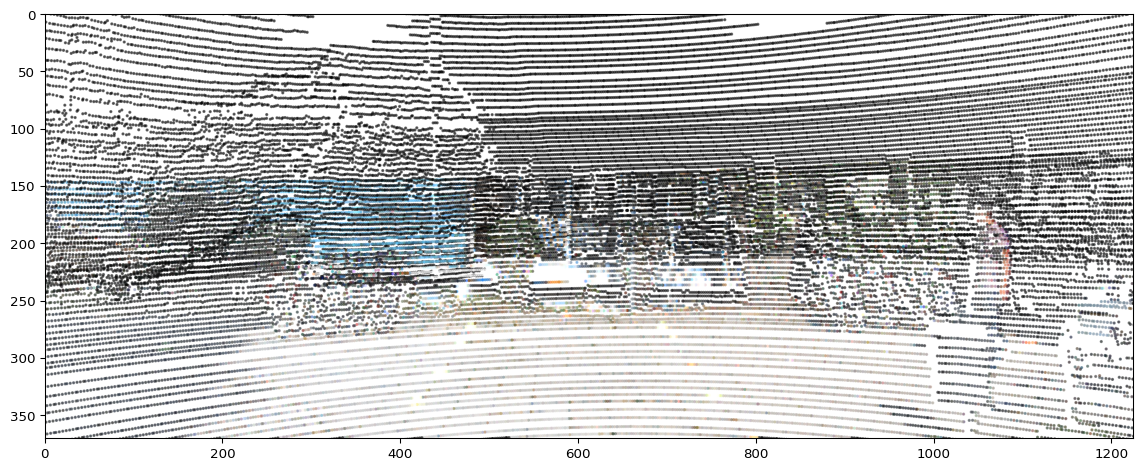

In [58]:
# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]  # lidar xyz (front, left, up)

# TODO: use fov filter?
velo = np.insert(points, 3, 1, axis=1).T
cam = P2.dot(R2_rect.dot(Tr_vel2cam.dot(velo)))
# cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)

# get u,v,z
cam[:2] /= cam[2, :]

# do projection staff
plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
png = mpimg.imread(img)
IMG_H, IMG_W, _ = png.shape

# restrict canvas in range
plt.axis([0, IMG_W, IMG_H, 0])

# plt.imshow(png)
# filter point out of canvas

u, v, z = cam
u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
# cam = np.delete(cam, np.where(outlier), axis=1)

# generate color map from depth
u, v, z = cam

# Adding rgb data
rgb_values = []
for u_coord, v_coord, z_coord in zip(u, v, z):
    u_int, v_int = int(round(u_coord)), int(round(v_coord))
    if z_coord >= 0:
        if 0 <= u_int < IMG_W and 0 <= v_int < IMG_H:
            rgb_value = png[v_int, u_int]
            rgb_values.append(rgb_value)
        else:
            rgb_values.append((0, 0, 0))
    else:
        rgb_values.append((0, 0, 0))

plt.scatter([u], [v],  c=rgb_values, alpha=0.5, s=2)
# plt.title(name)
# plt.savefig(f'{name}.png', bbox_inches='tight')
plt.show()

In [60]:
# Create Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
# point_cloud.points = o3d.utility.Vector3dVector(scan[:, :3])
point_cloud.points = o3d.utility.Vector3dVector(points)
point_cloud.colors = o3d.utility.Vector3dVector(rgb_values)
o3d.io.write_point_cloud("./../data/outputs/projected_sample.pcd", point_cloud)

True